In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
import random
from skimage.feature import graycomatrix, graycoprops
from scipy.ndimage import binary_dilation,binary_opening,binary_closing,binary_erosion
from skimage.morphology import disk
from sklearn.metrics import jaccard_score

In [2]:
# Set dataset paths
data_path = "../data/raw/data/"
mask_path = "../data/raw/masks/"

In [3]:
# Function to load a sample TIFF image
def load_tiff_image(image_path):
    with rasterio.open(image_path) as src:
        image = src.read()
    return image

In [4]:
# Function to load corresponding mask
def load_mask(mask_path):
    with rasterio.open(mask_path) as src:
        if src.count > 1:
            print(f"Warning: Mask {mask_path} has multiple bands ({src.count}). Using only the first band.")
        mask = src.read(1)  # Single-channel mask
    return mask

In [5]:
def compute_indices(image):
    nir = image[3]
    red = image[0]
    green = image[1]
    
    ndvi = (nir - red) / (nir + red + 1e-6)
    ndwi = (green - nir) / (green + nir + 1e-6)
    
    return ndvi, ndwi

In [6]:
# Load image and mask paths
image_paths = [os.path.join(data_path, f) for f in os.listdir(data_path) if f.endswith('.tif')]
mask_paths = [os.path.join(mask_path, f) for f in os.listdir(mask_path) if f.endswith('.tif')]

In [15]:
# Compute band ratios for a sample image
idx= random.randint(0, len(image_paths))
sample_image = load_tiff_image(image_paths[idx])
sample_mask_image = load_mask(mask_paths[idx])
ndvi, ndwi = compute_indices(sample_image)

0.0771099364869635


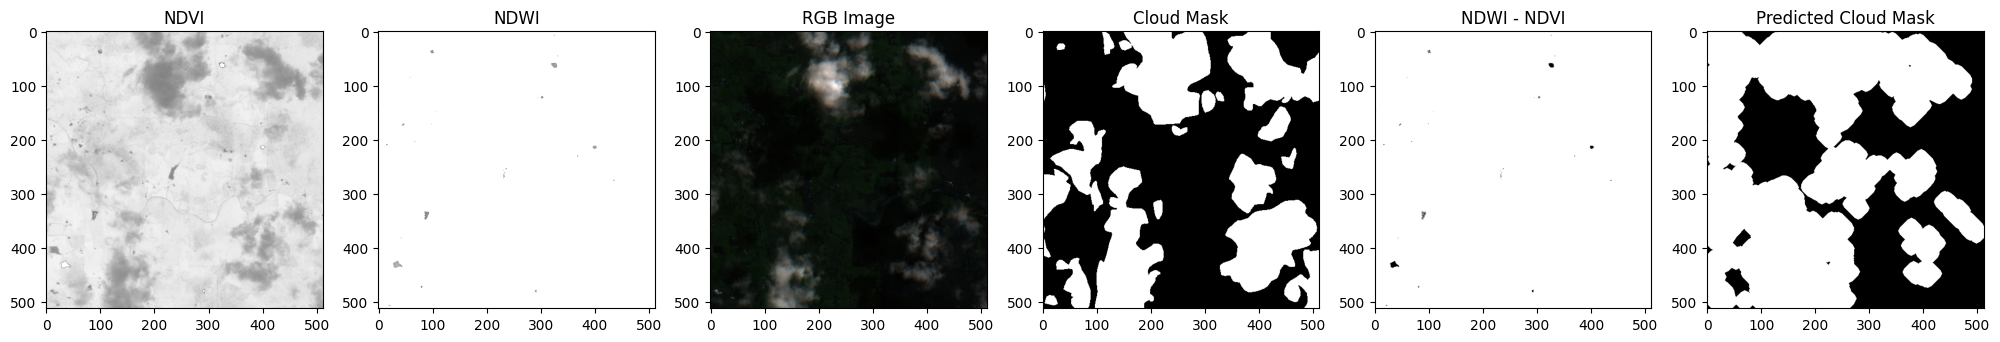

In [16]:
# Plot band ratios
fig, axes = plt.subplots(1, 6, figsize=(25, 5))

axes[0].imshow(ndvi, cmap='gray', vmin=-1, vmax=1)
axes[0].set_title("NDVI")

axes[1].imshow(ndwi, cmap='gray', vmin=-1, vmax=1)
axes[1].set_title("NDWI")

# Normalize RGB image for display
rgb_image = sample_image[:3].transpose(1, 2, 0)
rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

axes[2].imshow(rgb_image)
axes[2].set_title("RGB Image")

# Load and plot mask
axes[3].imshow(sample_mask_image, cmap='gray', vmin=0, vmax=1)
axes[3].set_title("Cloud Mask")

# Plot NDWI - NDVI
axes[4].imshow(ndwi - ndvi,cmap="gray",vmin=-1, vmax=1)
axes[4].set_title("NDWI - NDVI")

# plot NDSI
swir = sample_image[3]
green = sample_image[1]
ndsi = (green - swir) / (green + swir + 1e-6)
# ndsi += (ndwi - ndvi)
ndsi_min = np.min(ndsi)
ndsi_max = np.max(ndsi)
predicted_cloud_mask = (ndsi - ndsi_min) / (ndsi_max - ndsi_min + 1e-6)
threshold = np.clip(np.percentile(predicted_cloud_mask, 45), 0, 1) 
print(threshold)
predicted_cloud_mask = predicted_cloud_mask < threshold
predicted_cloud_mask = predicted_cloud_mask.astype(np.uint8)

# Apply morphological opening to remove noise
predicted_cloud_mask = binary_closing(predicted_cloud_mask, iterations=3)
predicted_cloud_mask = binary_opening(predicted_cloud_mask, iterations=10)

# Apply dilation to smoothen cloud edges
structuring_element = disk(3)
predicted_cloud_mask = binary_dilation(predicted_cloud_mask, iterations=3,structure=structuring_element)

# Plot the final predicted cloud mask
axes[5].imshow(predicted_cloud_mask, cmap='gray')
axes[5].set_title("Predicted Cloud Mask")

plt.show()


In [9]:
# Compute Dice coefficient
true_mask = sample_mask_image.astype(bool)  # Convert to boolean
predicted_mask = predicted_cloud_mask.astype(bool)

intersection = np.sum(true_mask & predicted_mask)
union = np.sum(true_mask) + np.sum(predicted_mask)
dice_coefficient = (2.0 * intersection) / (union + 1e-6)  # Avoid division by zero

print(f"Dice Coefficient: {dice_coefficient:.4f}")

Dice Coefficient: 0.8420


In [10]:
# Initialize counters
correct_predictions = 0
total_images = len(image_paths)

for i in range(total_images):
    # Load image and mask
    sample_image = load_tiff_image(image_paths[i])
    sample_mask_image = load_mask(mask_paths[i])
    
    # Compute indices
    ndvi, ndwi = compute_indices(sample_image)
    
    # Compute NDSI and apply NDWI-NDVI adjustment
    swir = sample_image[3]
    green = sample_image[1]
    ndsi = (green - swir) / (green + swir + 1e-6)
    # ndsi += (ndwi - ndvi)
    
    # Normalize NDSI
    ndsi_min = np.min(ndsi)
    ndsi_max = np.max(ndsi)
    predicted_cloud_mask = (ndsi - ndsi_min) / (ndsi_max - ndsi_min + 1e-6)
    
    # Compute variable threshold
    threshold = np.clip(np.percentile(predicted_cloud_mask, 45), 0, 1) 
    
    # Generate predicted cloud mask
    predicted_cloud_mask = predicted_cloud_mask < threshold
    predicted_cloud_mask = predicted_cloud_mask.astype(np.uint8)

    # Apply morphological operations
    predicted_cloud_mask = binary_closing(predicted_cloud_mask, iterations=3)
    predicted_cloud_mask = binary_opening(predicted_cloud_mask, iterations=10)
    
    # Apply dilation to smoothen cloud edges
    structuring_element = disk(3)
    predicted_cloud_mask = binary_dilation(predicted_cloud_mask, iterations=3,structure=structuring_element)
    
    # Compute Dice coefficient
    true_mask = sample_mask_image.astype(bool)
    predicted_mask = predicted_cloud_mask.astype(bool)
    
    intersection = np.sum(true_mask & predicted_mask)
    union = np.sum(true_mask) + np.sum(predicted_mask)
    dice_coefficient = (2.0 * intersection) / (union + 1e-6)

    # Check if Dice coefficient meets the threshold
    if dice_coefficient > 0.6:
        correct_predictions += 1

    print(f"Image {i+1}/{total_images} - Dice Coefficient: {dice_coefficient:.4f}")

# Compute final accuracy
accuracy = correct_predictions / total_images
print(f"\nFinal Accuracy: {accuracy:.4f}")


Image 1/500 - Dice Coefficient: 0.0000
Image 2/500 - Dice Coefficient: 0.1373
Image 3/500 - Dice Coefficient: 0.5318
Image 4/500 - Dice Coefficient: 0.0281
Image 5/500 - Dice Coefficient: 0.8510
Image 6/500 - Dice Coefficient: 0.8288
Image 7/500 - Dice Coefficient: 0.5536
Image 8/500 - Dice Coefficient: 0.0000
Image 9/500 - Dice Coefficient: 0.0259
Image 10/500 - Dice Coefficient: 0.6619
Image 11/500 - Dice Coefficient: 0.8399
Image 12/500 - Dice Coefficient: 0.7352
Image 13/500 - Dice Coefficient: 0.7474
Image 14/500 - Dice Coefficient: 0.1207
Image 15/500 - Dice Coefficient: 0.7697
Image 16/500 - Dice Coefficient: 0.8210
Image 17/500 - Dice Coefficient: 0.7626
Image 18/500 - Dice Coefficient: 0.0000
Image 19/500 - Dice Coefficient: 0.0000
Image 20/500 - Dice Coefficient: 0.7917
Image 21/500 - Dice Coefficient: 0.8384
Image 22/500 - Dice Coefficient: 0.1612
Image 23/500 - Dice Coefficient: 0.8829
Image 24/500 - Dice Coefficient: 0.0631
Image 25/500 - Dice Coefficient: 0.9042
Image 26/